In [52]:
#Importing libraries
import cv2
import os
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import csv
import pandas as pd
import keras
from keras import models,Model
from keras.layers import Dense,GaussianNoise, Dropout,Input
%matplotlib inline

In [53]:
#Importing data and initial pre-processing 
dataSet = []
person = []
horiSet = []

count = 0
folder = "D:\SEMESTER 6\MachineLearning\Project-1 Classification\ML_face_images\ML_face_images"
for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (100,100))
        img = np.ravel(img)
        if img is not None:
            numbers = re.findall('\d+',filename)
            numbers = list(map(int,numbers))
            person.append(numbers[0])
            horiSet.append(img.T)
            dataSet.append(img)
            count = count + 1
           
        
dataSet_test = []
person_test = []
horiSet_test = []

folder = "D:\SEMESTER 6\MachineLearning\Project-1 Classification\ML_face_images\Test"
for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (100, 100))
        img = np.ravel(img)
        if img is not None:
            numbers = re.findall('\d+',filename)
            numbers = list(map(int,numbers))
            person_test.append(numbers[0])
            horiSet_test.append(img.T)
            dataSet_test.append(img)
            count = count + 1

In [54]:
#Getting data in desired format and mapping the lables
dataSet = np.array(dataSet)
train = pd.DataFrame(dataSet)

person = np.array(person)
train['id'] = person.transpose()

unique_person = train['id']
unique_person = np.array(unique_person)
unique_person = np.unique(unique_person)
key = range(len(unique_person))

roll_dict = dict( zip(unique_person, key))

mapped_roll = np.vectorize(roll_dict.get)(person)
train['id'] = mapped_roll.transpose()

y = train['id'].values.astype('int64')
images = train.drop(['id'], axis=1, inplace=False)
x = (images.values).astype('uint8')

X_train = x
Y_train = y

dataSet_test = np.array(dataSet_test)
test = pd.DataFrame(dataSet_test)

person_test = np.array(person_test)
test['id'] = person_test.transpose()
print(test)

mapped_roll_test = np.vectorize(roll_dict.get)(person_test)
test['id'] = mapped_roll_test.transpose()

y_test = test['id'].values.astype('int64')
images = test.drop(['id'], axis=1, inplace=False)
x_test = (images.values).astype('uint8')

X_test = x_test
Y_test = y_test

     0    1    2    3    4    5    6    7    8    9    ...      249991  \
0  255  255  255  255  255  255  255  255  255  255    ...         255   
1  204  207  209  209  208  207  206  207  209  209    ...          57   

   249992  249993  249994  249995  249996  249997  249998  249999         id  
0     255     255     255     255     255     255     255     255  201501009  
1      59      58      57      55      53      53      51      48  201501009  

[2 rows x 250001 columns]


In [55]:
#Standardize data. It is fitted to train data, as we assume no knowledge of test data.
scalar = StandardScaler()
scalar.fit(X_train)
X_sc_train = scalar.transform(X_train)
X_sc_test = scalar.transform(X_test)

C:\Users\Jeet J\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0,0.5,'Variance')

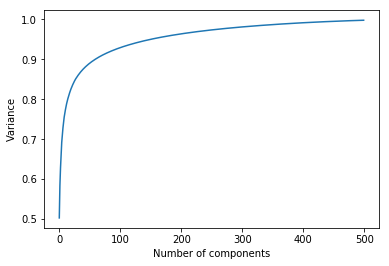

In [56]:
#Checcking for most essential components by looking at the cummulative co-variance
pca = PCA(n_components=500)
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance')

(598, 150)
(598, 250000)


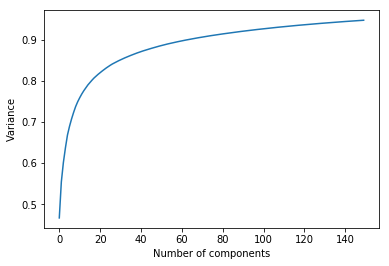

In [57]:
#Looking at above graph we can now take 150 components and transform the data set along principle components
pca = PCA(n_components=150)
X_pca_train = pca.fit_transform(X_sc_train)
X_pca_test = pca.transform(X_sc_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance')

print(X_pca_train.shape)
print(X_sc_train.shape)


In [58]:
inv_pca = pca.inverse_transform(X_pca_train)
inv_sc = scalar.inverse_transform(inv_pca)

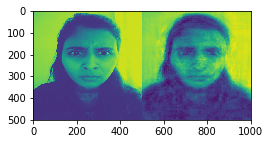

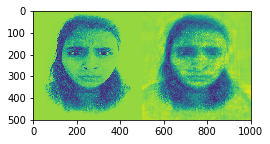

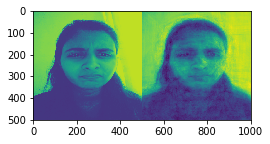

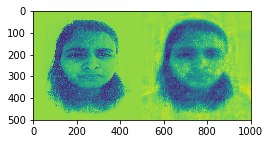

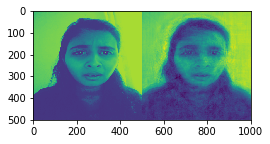

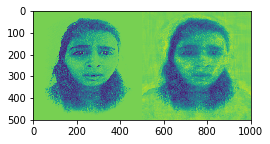

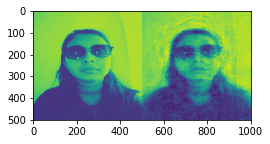

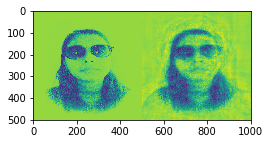

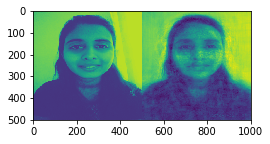

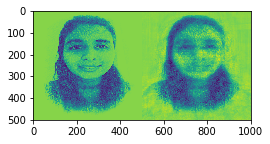

In [59]:
def side_by_side(indexes):
    org = X_train[indexes].reshape(100,100)
    rec = inv_sc[indexes].reshape(100,100)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(4,2))
    plt.imshow(pair)
    plt.show()
    
for index in range(0,10):
    side_by_side(index)

In [60]:
inv_pca = pca.inverse_transform(X_pca_test)
inv_sc = scalar.inverse_transform(inv_pca)

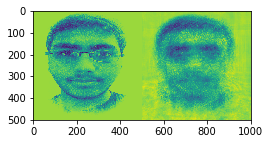

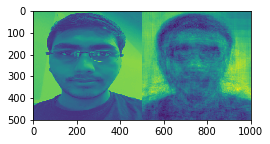

In [61]:
def side_by_side(indexes):
    org = X_test[indexes].reshape(100,100)
    rec = inv_sc[indexes].reshape(100,100)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(4,2))
    plt.imshow(pair)
    plt.show()
    
for index in range(0,7):
    side_by_side(index)

In [62]:
#Defining and training of the neural neural network
model = models.Sequential()
layers = 1
units = 108

#Input layer
model.add(Dense(units, input_dim=150, activation='relu'))

#Hidden Layer
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(0.1))
    
#Output layer
model.add(Dense(40, activation='softmax'))

#Building model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Rmsprop', metrics=['accuracy'])

#Training model
model.fit(X_pca_train,Y_train,batch_size=100,validation_split=0.2,epochs=100,verbose=2)

Train on 478 samples, validate on 120 samples
Epoch 1/100
 - 0s - loss: 15.0697 - acc: 0.0439 - val_loss: 15.3946 - val_acc: 0.0167
Epoch 2/100
 - 0s - loss: 13.9566 - acc: 0.1025 - val_loss: 15.4272 - val_acc: 0.0167
Epoch 3/100
 - 0s - loss: 13.3051 - acc: 0.1423 - val_loss: 15.7012 - val_acc: 0.0083
Epoch 4/100
 - 0s - loss: 12.6621 - acc: 0.1799 - val_loss: 15.6131 - val_acc: 0.0083
Epoch 5/100
 - 0s - loss: 12.1954 - acc: 0.2008 - val_loss: 15.5246 - val_acc: 0.0000e+00
Epoch 6/100
 - 0s - loss: 11.8340 - acc: 0.2197 - val_loss: 15.8149 - val_acc: 0.0000e+00
Epoch 7/100
 - 0s - loss: 11.1453 - acc: 0.2636 - val_loss: 15.8143 - val_acc: 0.0000e+00
Epoch 8/100
 - 0s - loss: 10.6300 - acc: 0.2950 - val_loss: 15.7407 - val_acc: 0.0000e+00
Epoch 9/100
 - 0s - loss: 10.0782 - acc: 0.3305 - val_loss: 15.7333 - val_acc: 0.0000e+00
Epoch 10/100
 - 0s - loss: 9.9049 - acc: 0.3536 - val_loss: 15.5677 - val_acc: 0.0000e+00
Epoch 11/100
 - 0s - loss: 9.6084 - acc: 0.3682 - val_loss: 15.4853 - 

Epoch 92/100
 - 0s - loss: 1.6061 - acc: 0.8975 - val_loss: 15.8041 - val_acc: 0.0000e+00
Epoch 93/100
 - 0s - loss: 1.5906 - acc: 0.8996 - val_loss: 15.8558 - val_acc: 0.0000e+00
Epoch 94/100
 - 0s - loss: 1.5853 - acc: 0.9017 - val_loss: 15.8509 - val_acc: 0.0000e+00
Epoch 95/100
 - 0s - loss: 1.5958 - acc: 0.8975 - val_loss: 15.7771 - val_acc: 0.0000e+00
Epoch 96/100
 - 0s - loss: 1.6320 - acc: 0.8891 - val_loss: 15.8198 - val_acc: 0.0000e+00
Epoch 97/100
 - 0s - loss: 1.5878 - acc: 0.8996 - val_loss: 15.8873 - val_acc: 0.0000e+00
Epoch 98/100
 - 0s - loss: 1.6206 - acc: 0.8996 - val_loss: 15.8734 - val_acc: 0.0000e+00
Epoch 99/100
 - 0s - loss: 1.5890 - acc: 0.8996 - val_loss: 15.9441 - val_acc: 0.0000e+00
Epoch 100/100
 - 0s - loss: 1.5861 - acc: 0.9017 - val_loss: 15.9426 - val_acc: 0.0000e+00


In [63]:
#Recognizing the faces from training set
predictions = model.predict_classes(X_pca_test, verbose=0)

def write_predictions(predictions, fname):
    pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)), "id": predictions}).to_csv(fname, index=False, header=True)

write_predictions(predictions, "pca-out.csv")

In [64]:
#Reading the output of neural network and calculating the error
result = pd.read_csv('pca-out.csv')
result = result['id']
result = np.array(result)

error = np.array( Y_test - result)
error = error[error != 0]
error = error.size/Y_test.size

print('Accuracy : ',1-error)

result

Accuracy :  0.0


array([15, 25], dtype=int64)

In [65]:
roll_dict

{1744001: 0,
 1744002: 1,
 1744003: 2,
 1849004: 3,
 17440004: 4,
 20180119: 5,
 201501004: 6,
 201501007: 7,
 201501008: 8,
 201501009: 9,
 201501011: 10,
 201501012: 11,
 201501021: 12,
 201501025: 13,
 201501028: 14,
 201501031: 15,
 201501032: 16,
 201501034: 17,
 201501038: 18,
 201501039: 19,
 201501051: 20,
 201501053: 21,
 201501054: 22,
 201501055: 23,
 201501060: 24,
 201501067: 25,
 201501070: 26,
 201501071: 27,
 201501077: 28,
 201501079: 29,
 201501086: 30,
 201501088: 31,
 201501091: 32,
 201501095: 33,
 201501097: 34,
 201501101: 35,
 201501104: 36,
 201501109: 37,
 201501112: 38,
 201501121: 39}